# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook



# Getting Started- Load Python Packages

## Install all the packages through FinRL library


In [1]:
!pip install wrds
!pip install swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /private/var/folders/6p/wq3sknmj60d01hr19w3yktxm0000gn/T/pip-req-build-4pw_cc7g
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /private/var/folders/6p/wq3sknmj60d01hr19w3yktxm0000gn/T/pip-req-build-4pw_cc7g
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 3c64c50e3314d71a1715ad8a429fa3f2c4e5d0c8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/quantopian/pyfolio.git to /private/var/folders/6p/wq3sknmj60d01hr19w3yktxm0000gn/T/pip-install-y86evj_5/pyfolio_a491087af8654c35b79457da1b71dddf
  Running command git clone --filter=blob:none --quiet https://github.com/quantopian/pyfolio.git /private/var/folders/6p/wq3sknmj60d01hr19w3yktxm0000gn/T/pip-install-y86evj_5/pyfolio_a491087af8654c35b79457da1b71dddf
  Resolved https://github.com/qu

## Import Packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

# Load Data

In [5]:
TRAIN_START_DATE = "2010-01-01"
TRAIN_END_DATE = "2019-12-31"
TEST_START_DATE = "2020-01-01"
TEST_END_DATE = "2023-03-01"

In [6]:
ticker_universe = [
  "AAPL",
  "MSFT",
  "GOOG",
  "AMZN",
  # "BRK.B",
  "TSLA",
  "NVDA",
  "META",
  "XOM",
  "UNH",
  "JPM",
  "V",
  "JNJ",
  "WMT",
  "MA",
  "PG",
  "CVX",
  "HD",
  "LLY",
  "ABBV",
  "BAC",
  "MRK",
  "AVGO",
  "KO",
  "ORCL",
  "PEP",
  "PFE",
  "TMO",
  "COST",
  "CSCO",
  "MCD",
  "NKE",
  "CRM",
  "DIS",
  "DHR",
  "ABT",
  "LIN",
  "WFC",
  "TMUS",
  "ACN",
  "MS",
  "VZ",
  "UPS",
  "TXN",
  "ADBE",
  "CMCSA",
  "PM",
  "NEE",
  "BMY",
  "RTX",
  "COP"
]

In [7]:
len(ticker_universe)

50

In [8]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = ticker_universe).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [11]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed

Successfully added technical indicators
Successfully added turbulence index


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2010-01-04,7.622500,7.660714,7.585000,6.505281,493729600,AAPL,0,0.000000,6.526808,6.495000,100.000000,66.666667,100.000000,6.505281,6.505281,0.00000
1,2010-01-04,26.000362,26.177889,25.870815,19.433035,10829095,ABT,0,0.000000,6.526808,6.495000,100.000000,66.666667,100.000000,19.433035,19.433035,0.00000
2,2010-01-04,41.520000,42.200001,41.500000,32.836597,3650100,ACN,0,0.000000,6.526808,6.495000,100.000000,66.666667,100.000000,32.836597,32.836597,0.00000
3,2010-01-04,36.650002,37.299999,36.650002,37.090000,4710200,ADBE,0,0.000000,6.526808,6.495000,100.000000,66.666667,100.000000,37.090000,37.090000,0.00000
4,2010-01-04,6.812500,6.830500,6.657000,6.695000,151998000,AMZN,0,0.000000,6.526808,6.495000,100.000000,66.666667,100.000000,6.695000,6.695000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155612,2023-02-28,220.000000,221.770004,219.500000,219.940002,5385400,V,1,-0.503228,234.738237,217.596701,50.986160,-95.951653,14.510100,225.478670,218.383917,42.60495
155613,2023-02-28,38.700001,38.970001,38.549999,38.810001,16685300,VZ,1,-0.369096,42.250544,38.079457,46.456076,-148.233860,23.267346,40.217333,39.341519,42.60495
155614,2023-02-28,46.669998,47.029999,46.540001,46.770000,18627200,WFC,1,0.467675,48.731290,45.822002,55.524648,23.856444,14.846140,46.336901,44.237055,42.60495
155615,2023-02-28,141.000000,142.649994,140.949997,142.130005,6018000,WMT,1,-0.138707,147.737118,139.199884,48.541128,-41.652048,7.250607,142.988334,144.336602,42.60495


In [12]:
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

In [13]:
processed

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2010-01-04,7.622500,7.660714,7.585000,6.505281,493729600,AAPL,0,0.000000,6.526808,6.495000,100.000000,66.666667,100.000000,6.505281,6.505281,0.00000
1,2010-01-04,26.000362,26.177889,25.870815,19.433035,10829095,ABT,0,0.000000,6.526808,6.495000,100.000000,66.666667,100.000000,19.433035,19.433035,0.00000
2,2010-01-04,41.520000,42.200001,41.500000,32.836597,3650100,ACN,0,0.000000,6.526808,6.495000,100.000000,66.666667,100.000000,32.836597,32.836597,0.00000
3,2010-01-04,36.650002,37.299999,36.650002,37.090000,4710200,ADBE,0,0.000000,6.526808,6.495000,100.000000,66.666667,100.000000,37.090000,37.090000,0.00000
4,2010-01-04,6.812500,6.830500,6.657000,6.695000,151998000,AMZN,0,0.000000,6.526808,6.495000,100.000000,66.666667,100.000000,6.695000,6.695000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155612,2023-02-28,220.000000,221.770004,219.500000,219.940002,5385400,V,1,-0.503228,234.738237,217.596701,50.986160,-95.951653,14.510100,225.478670,218.383917,42.60495
155613,2023-02-28,38.700001,38.970001,38.549999,38.810001,16685300,VZ,1,-0.369096,42.250544,38.079457,46.456076,-148.233860,23.267346,40.217333,39.341519,42.60495
155614,2023-02-28,46.669998,47.029999,46.540001,46.770000,18627200,WFC,1,0.467675,48.731290,45.822002,55.524648,23.856444,14.846140,46.336901,44.237055,42.60495
155615,2023-02-28,141.000000,142.649994,140.949997,142.130005,6018000,WMT,1,-0.138707,147.737118,139.199884,48.541128,-41.652048,7.250607,142.988334,144.336602,42.60495


In [14]:
all_dates = processed.date.unique()
all_dates.sort()
all_dates

array(['2010-01-04', '2010-01-05', '2010-01-06', ..., '2023-02-24',
       '2023-02-27', '2023-02-28'], dtype=object)

In [15]:
len(ticker_universe)

50

# Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [16]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 47, State Space: 471


In [17]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [18]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)


In [19]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

In [ ]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2022-02-08,2022-05-10,A2C,-0.137993,-0.282172,-0.21605
1,189,2022-05-10,2022-08-10,DDPG,0.210952,0.139744,0.25109


# Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [ ]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [ ]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

In [ ]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2022-05-10,NaN,2022-05-10
1,9.953815e+05,2022-05-11,-0.004619,2022-05-11
2,9.946443e+05,2022-05-12,-0.000741,2022-05-12
3,1.019114e+06,2022-05-13,0.024601,2022-05-13
4,1.019246e+06,2022-05-16,0.000129,2022-05-16


<AxesSubplot:>

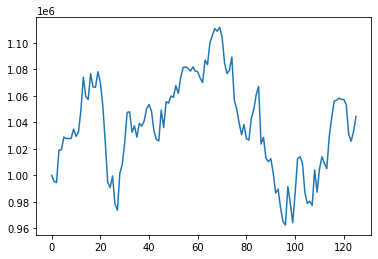

In [ ]:
%matplotlib inline
df_account_value.account_value.plot()

## BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.090960
Cumulative returns     0.044490
Annual volatility      0.202139
Sharpe ratio           0.534512
Calmar ratio           0.677445
Stability              0.031731
Max drawdown          -0.134270
Omega ratio            1.094194
Sortino ratio          0.782657
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.164464
Daily value at risk   -0.025038
dtype: float64


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^GSPC", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (125, 8)
Annual return         -0.112744
Cumulative returns    -0.057610
Annual volatility      0.250298
Sharpe ratio          -0.357203
Calmar ratio          -0.666580
Stability              0.144031
Max drawdown          -0.169137
Omega ratio            0.944585
Sortino ratio         -0.496381
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.933194
Daily value at risk   -0.031889
dtype: float64


## BackTestPlot

==============Compare to SP500===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (125, 8)


Start date,2022-05-10
End date,2022-11-07
Total months,6
,Backtest
Annual return,9.096%
Cumulative returns,4.449%
Annual volatility,20.214%
Sharpe ratio,0.53
Calmar ratio,0.68
Stability,0.03
Max drawdown,-13.427%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,13.43,2022-08-18,2022-09-27,NaT,NaN
1,9.70,2022-06-07,2022-06-17,2022-07-28,38
2,1.56,2022-05-27,2022-06-01,2022-06-02,5
3,1.09,2022-08-03,2022-08-09,2022-08-10,6
4,0.95,2022-06-02,2022-06-06,2022-06-07,4


Stress Events,mean,min,max
New Normal,0.04%,-4.07%,3.01%


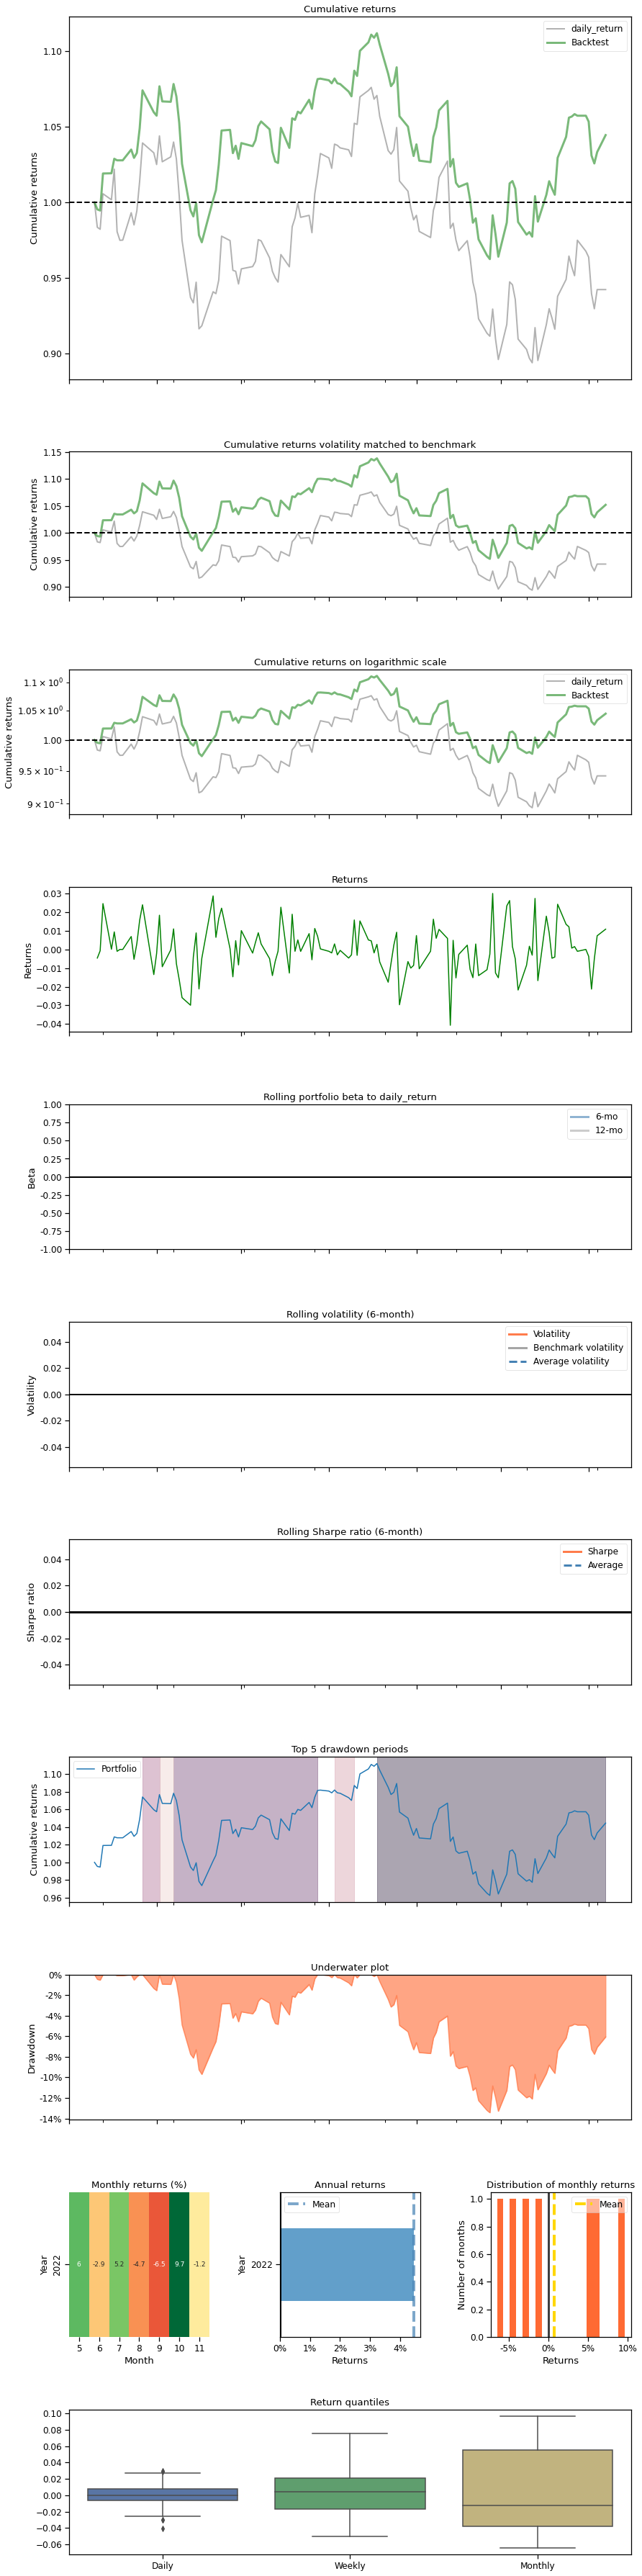

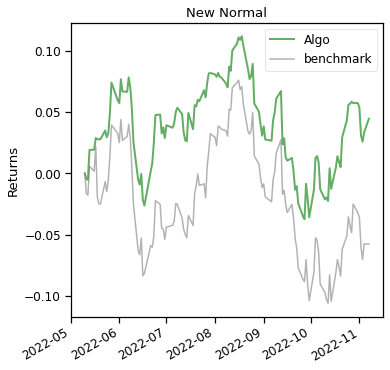

In [ ]:
print("==============Compare to SP500===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
              baseline_ticker = '^GSPC', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])